Name: 
### **Shreyas Raut**

PRN: 
### **240340128030**

# Image Processing with Neural Network

## Assignment A06 : 
## Working with PyTorch
- Custom DataSet with common transformation
- ${swish}$ activation function
- Regularizations:
    - L2, 
    - BatchNorm,
    - Dropout, 
    - Early Stopping
    
- multi-class output
- FIFA dataset 

In [1]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [2]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../Input'
outDir = '../Output'
modelDir = '../Models'
subDir = 'fifa_2019'

RANDOM_STATE = 24
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 501 # No. of Epoch
ALPHA = 0.001 # Learning Rate
BATCH_SIZE = 32 # Batch Size
TEST_SIZE = 0.2 # Test Size
WEIGHT_DECAY = 0.001 # Weight decay / L2 Penalty

# Parameters for Early Stopping
PATIENCE = 20
LR_PATIENCE = 10
LR_FACTOR = 0.1

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.brg

plt.rcParams.update(params)

In [3]:
print (fn_plot_torch_hist.__doc__)

None


In [4]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [5]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

In [6]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [7]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [8]:
data_df.shape

(18207, 89)

In [9]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [10]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [11]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [12]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [13]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [14]:
class_labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}
class_labels

{0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [15]:
X = data_df.drop('Position', axis=1)
y = data_df['Position'].to_numpy()

In [16]:
# splitting in train ans test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     stratify=y,
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517,) (3630, 33) (3630,)


In [17]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [18]:
class FIFA2019Dataset(Dataset):
    def __init__(self, X, y, device):
        self.X = torch.tensor(X, dtype=torch.float32, device=device)
        self.y = torch.tensor(y, dtype=torch.int64, device=device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [19]:
class FIFA2019Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FIFA2019Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.SiLU(),
            nn.Dropout(0.5)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.SiLU(),
            nn.Dropout(0.6)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.SiLU(),
            nn.Dropout(0.7)
        )
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output(x)
        return x


In [20]:
# Prepare datasets
train_ds = FIFA2019Dataset(X_train, y_train, device)
test_ds = FIFA2019Dataset(X_test, y_test, device)

# Prepare data loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


In [21]:
input_dim = X_train.shape[1]
output_dim = len(class_labels)

model = FIFA2019Model(input_dim, output_dim).to(device)


In [22]:
print(model)

FIFA2019Model(
  (layer1): Sequential(
    (0): Linear(in_features=33, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Dropout(p=0.6, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Dropout(p=0.7, inplace=False)
  )
  (output): Linear(in_features=32, out_features=4, bias=True)
)


In [23]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=ALPHA, 
                             weight_decay=WEIGHT_DECAY
                            )

# Learning Rate scheduler - Reduce learning rate when a metric has stopped improving.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', 
                                                     factor=LR_FACTOR,  #  new_lr = LR_FACTOR * old_factor. 
                                                     patience=LR_PATIENCE,
                                                     min_lr=1e-5)

# Min Loss - for Early Stopping
minLoss = float('inf')

# Path for saving the model
savePath = os.path.join(modelDir, subDir, 'iono.pth')

# Train the model for multiple epochs

for epoch in range(EPOCHS):
    
    model.train()
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    counter = 0
    
    with torch.no_grad():
        
        for data in test_loader:
            
            inputs, labels = data
            
            outputs = model(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)
    
    
    scheduler.step(test_loss)

    # Adding early stopping / Model Saving

    if test_loss < minLoss:
        minLoss = test_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), os.path.join(modelDir, subDir, 'best_model.pth'))
    else:
        early_stopping_counter += 1
    
    if early_stopping_counter > PATIENCE:
        print(f"Early stopping at epoch {epoch}")
        break
    
    if epoch % 5 == 0:
        print(f'At epoch {epoch:3d} | Loss: {train_loss:.4f}/{test_loss:.4f} | Acc:{train_acc:.4f}/{test_acc:.4f} | LR: {scheduler.get_last_lr()[0]:.5f} | Counter: {counter}')

At epoch   0 | Loss: 0.7363/0.5374 | Acc:0.7339/0.7983 | LR: 0.00100 | Counter: 0
At epoch   5 | Loss: 0.4194/0.4203 | Acc:0.8413/0.8322 | LR: 0.00100 | Counter: 0
At epoch  10 | Loss: 0.4039/0.4132 | Acc:0.8454/0.8416 | LR: 0.00100 | Counter: 0
At epoch  15 | Loss: 0.4025/0.4067 | Acc:0.8444/0.8433 | LR: 0.00100 | Counter: 0
At epoch  20 | Loss: 0.3992/0.4064 | Acc:0.8458/0.8435 | LR: 0.00100 | Counter: 0
At epoch  25 | Loss: 0.4047/0.4184 | Acc:0.8465/0.8353 | LR: 0.00010 | Counter: 0
At epoch  30 | Loss: 0.3909/0.3970 | Acc:0.8501/0.8413 | LR: 0.00010 | Counter: 0
At epoch  35 | Loss: 0.3898/0.3948 | Acc:0.8516/0.8477 | LR: 0.00010 | Counter: 0
At epoch  40 | Loss: 0.3859/0.3886 | Acc:0.8533/0.8510 | LR: 0.00010 | Counter: 0
At epoch  45 | Loss: 0.3861/0.3958 | Acc:0.8515/0.8452 | LR: 0.00010 | Counter: 0
At epoch  50 | Loss: 0.3880/0.3990 | Acc:0.8482/0.8499 | LR: 0.00010 | Counter: 0
At epoch  55 | Loss: 0.3848/0.3870 | Acc:0.8511/0.8523 | LR: 0.00010 | Counter: 0
At epoch  60 | L

In [24]:
loss_df = pd.DataFrame({'epoch': n_epoch, 'loss' : loss, 'test_loss' : tloss, 'acc' : acc, 'test_acc': tacc})
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,0.736283,0.537414,0.733898,0.798347
1,1,0.497970,0.468188,0.818626,0.825895
2,2,0.464804,0.454027,0.826342,0.830028
3,3,0.447930,0.431439,0.832403,0.835537
4,4,0.432461,0.421687,0.835985,0.838017


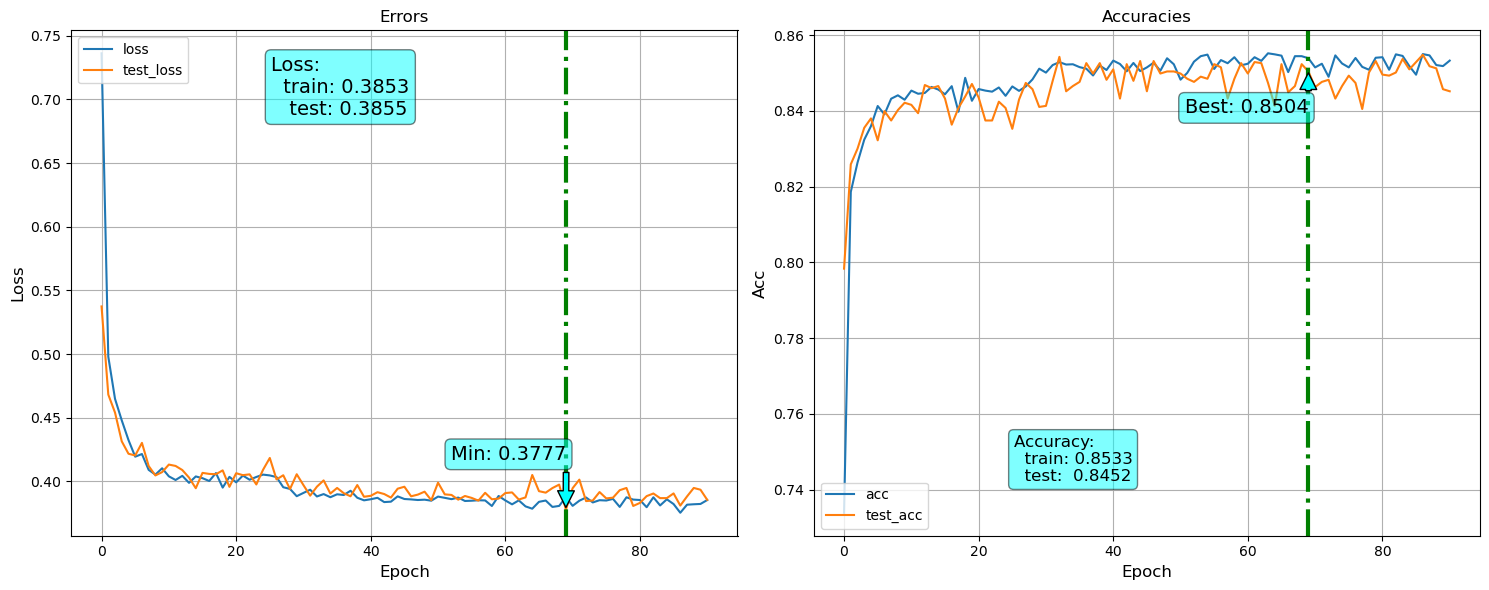

In [25]:
fn_plot_torch_hist(loss_df)

In [26]:
y_train = []
y_pred = []
for i, data in enumerate(train_loader):
    
    inputs, labels = data
    
    outputs = model(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_train.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1620
           1       0.90      0.89      0.89      4693
           2       0.80      0.84      0.82      5470
           3       0.83      0.75      0.79      2734

    accuracy                           0.86     14517
   macro avg       0.88      0.87      0.87     14517
weighted avg       0.86      0.86      0.86     14517



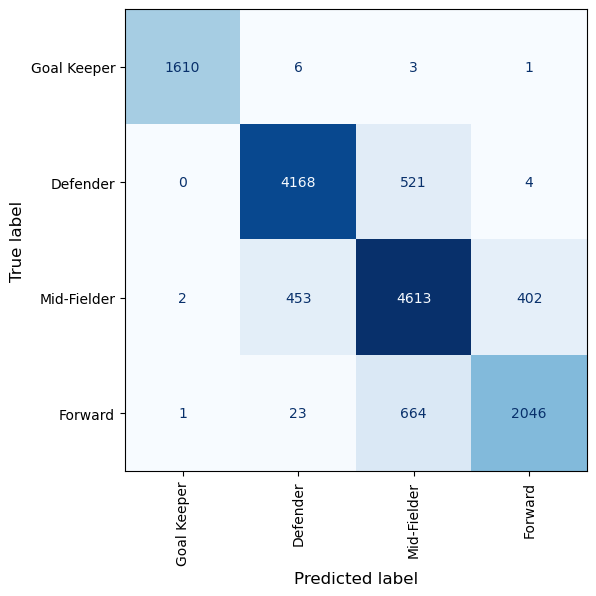

In [27]:
fn_plot_confusion_matrix(y_train, y_pred, class_labels)

In [28]:
y_test = []
y_pred = []
for i, data in enumerate(test_loader):
    
    inputs, labels = data
    
    outputs = model(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_test.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

print(classification_report(y_test, y_pred ))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       405
           1       0.89      0.90      0.89      1173
           2       0.79      0.83      0.81      1368
           3       0.81      0.73      0.77       684

    accuracy                           0.85      3630
   macro avg       0.87      0.86      0.87      3630
weighted avg       0.85      0.85      0.85      3630



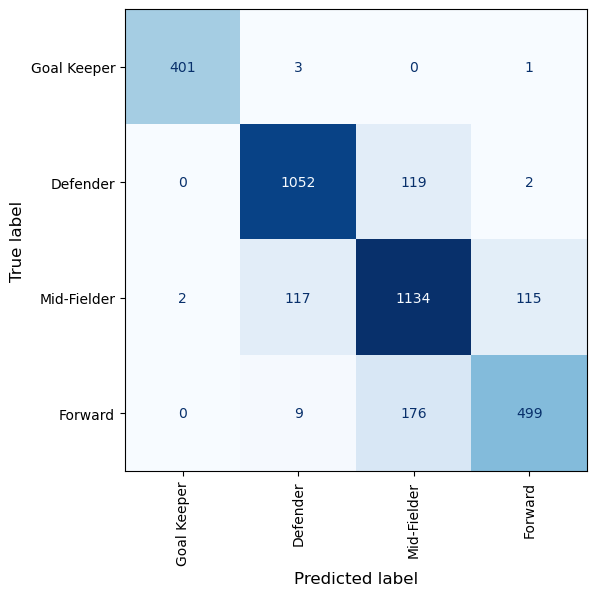

In [29]:
fn_plot_confusion_matrix(y_test, y_pred, class_labels)

| #  | Nodes in Respective Layers (Hidden Layers - 03) | Activation Function | Regularization Technique                                       | Test Loss | Test Accuracy | Comment                                                                                                                                                                                                                    |
| -- | ----------------------------------------------- | ------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------- | --------- | ------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1  | 33-128-64-32-4                                  | Swish()             | N/A                                                                                                                                                                                                                     | 0.2898    | 0.8719        | Base Case |
| 2  | 33-128-64-32-4                                  | Swish()             | Weight Decay + Early Stopping                                 |  0.2875    | 0.8758        | Accuracy increases slightly|
| 3  | 33-128-64-32-4                                  | Swish()             | Weight Decay + Early Stopping + Dropout (0.1,0.2,0.3)                      |  0.2967    | 0.8758        | NO change|
| 4  | 33-128-64-32-4                                  | Swish()             | Weight Decay + Early Stopping + Uniform Dropout Rate (0.1)                      | 0.294     | 0.8755        | No significant drop.|
| 5 | 33-128-64-32-4                                  | Swish()             | Weight Decay + Early Stopping + Dropout + Batch Normalization |  0.3489    | 0.8543        | No significant drop. |
